<a href="https://colab.research.google.com/github/varikulppala/AI-CHATBOT-WITH-NLP/blob/main/ADITHYASNAPANDSHOPPROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 6: Extract the zip file
!unzip /content/ECOMMERCE_PRODUCT_IMAGES.zip

Streaming output truncated to the last 5000 lines.
  inflating: ECOMMERCE_PRODUCT_IMAGES/train/PET_SUPPLIES/12636_PET_SU_train.jpeg  
  inflating: ECOMMERCE_PRODUCT_IMAGES/train/PET_SUPPLIES/12637_PET_SU_train.jpeg  
  inflating: ECOMMERCE_PRODUCT_IMAGES/train/PET_SUPPLIES/12638_PET_SU_train.jpeg  
  inflating: ECOMMERCE_PRODUCT_IMAGES/train/PET_SUPPLIES/12639_PET_SU_train.jpeg  
  inflating: ECOMMERCE_PRODUCT_IMAGES/train/PET_SUPPLIES/12640_PET_SU_train.jpeg  
  inflating: ECOMMERCE_PRODUCT_IMAGES/train/PET_SUPPLIES/12641_PET_SU_train.jpeg  
  inflating: ECOMMERCE_PRODUCT_IMAGES/train/PET_SUPPLIES/12642_PET_SU_train.jpeg  
  inflating: ECOMMERCE_PRODUCT_IMAGES/train/PET_SUPPLIES/12643_PET_SU_train.jpeg  
  inflating: ECOMMERCE_PRODUCT_IMAGES/train/PET_SUPPLIES/12644_PET_SU_train.jpeg  
  inflating: ECOMMERCE_PRODUCT_IMAGES/train/PET_SUPPLIES/12645_PET_SU_train.jpeg  
  inflating: ECOMMERCE_PRODUCT_IMAGES/train/PET_SUPPLIES/12646_PET_SU_train.jpeg  
  inflating: ECOMMERCE_PRODUCT_IMAGE

In [2]:
# Cell 1: Paths & basic checks (no TensorFlow import here yet)
import os, sys
print("Python:", sys.version)

DATASET_ROOT = "/content/ECOMMERCE_PRODUCT_IMAGES"
TRAIN_DIR = os.path.join(DATASET_ROOT, "train")
VAL_DIR = os.path.join(DATASET_ROOT, "val")
CHECK_DIR = os.path.join(DATASET_ROOT, "check")

for p in [DATASET_ROOT, TRAIN_DIR, VAL_DIR, CHECK_DIR]:
    print(p, "exists:", os.path.exists(p))

# Quick listing of top-level classes (if present)
if os.path.exists(TRAIN_DIR):
    print("\nSample classes in train (up to 20):", os.listdir(TRAIN_DIR)[:20])

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
/content/ECOMMERCE_PRODUCT_IMAGES exists: True
/content/ECOMMERCE_PRODUCT_IMAGES/train exists: True
/content/ECOMMERCE_PRODUCT_IMAGES/val exists: True
/content/ECOMMERCE_PRODUCT_IMAGES/check exists: True

Sample classes in train (up to 20): ['PET_SUPPLIES', 'HOME_KITCHEN_TOOLS', 'SPORTS_OUTDOOR', 'ELECTRONICS', 'CLOTHING_ACCESSORIES_JEWELLERY', 'BEAUTY_HEALTH', 'HOBBY_ARTS_STATIONERY', 'GROCERY', 'BABY_PRODUCTS']


In [3]:
# Cell 2: Install / Import (uncomment pip install lines in Colab if needed)
# If running in Colab and you don't have TF or other libraries, uncomment the following:
# !pip install -q tensorflow opencv-python-headless==4.7.0.72 sentence-transformers

try:
    import tensorflow as tf
    from tensorflow.keras.applications import MobileNetV2
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    from tensorflow.keras import layers, models, optimizers, callbacks
    from tensorflow.keras.models import load_model
    import numpy as np
    import cv2
    print("Imported TensorFlow, Keras, OpenCV, numpy")
    print("TensorFlow version:", tf.__version__)
    print("GPUs available:", tf.config.list_physical_devices('GPU'))
except Exception as e:
    print("Import error (install required packages if running this notebook):", e)
    print("If you are in Colab, run: !pip install -q tensorflow opencv-python-headless sentence-transformers")

Imported TensorFlow, Keras, OpenCV, numpy
TensorFlow version: 2.19.0
GPUs available: []


In [4]:
# Cell 3: Dataset inspection: count images per class in train/val/check
import os

def folder_class_counts(path):
    classes = {}
    if not os.path.exists(path):
        return classes
    for c in sorted(os.listdir(path)):
        c_path = os.path.join(path, c)
        if os.path.isdir(c_path):
            count = sum([len(files) for r,d,files in os.walk(c_path)])
            classes[c] = count
    return classes

train_classes = folder_class_counts(TRAIN_DIR)
val_classes = folder_class_counts(VAL_DIR)
check_classes = folder_class_counts(CHECK_DIR)

print('Number of classes - train:', len(train_classes))
print('Train class counts (sample 20):', list(train_classes.items())[:20])
print('Number of classes - val:', len(val_classes))
print('Val class counts (sample 20):', list(val_classes.items())[:20])
print('Check class counts (sample 20):', list(check_classes.items())[:20])

total_train = sum(train_classes.values())
total_val = sum(val_classes.values())
total_check = sum(check_classes.values())
print(f"Total images — train: {total_train}, val: {total_val}, check: {total_check}")

Number of classes - train: 9
Train class counts (sample 20): [('BABY_PRODUCTS', 1087), ('BEAUTY_HEALTH', 1202), ('CLOTHING_ACCESSORIES_JEWELLERY', 1071), ('ELECTRONICS', 1353), ('GROCERY', 3978), ('HOBBY_ARTS_STATIONERY', 1091), ('HOME_KITCHEN_TOOLS', 1715), ('PET_SUPPLIES', 1260), ('SPORTS_OUTDOOR', 1235)]
Number of classes - val: 9
Val class counts (sample 20): [('BABY_PRODUCTS', 282), ('BEAUTY_HEALTH', 312), ('CLOTHING_ACCESSORIES_JEWELLERY', 278), ('ELECTRONICS', 351), ('GROCERY', 1033), ('HOBBY_ARTS_STATIONERY', 283), ('HOME_KITCHEN_TOOLS', 445), ('PET_SUPPLIES', 327), ('SPORTS_OUTDOOR', 321)]
Check class counts (sample 20): [('BABY_PRODUCTS', 43), ('BEAUTY_HEALTH', 48), ('CLOTHING_ACCESSORIES_JEWELLERY', 42), ('ELECTRONICS', 53), ('GROCERY', 155), ('HOBBY_ARTS_STATIONERY', 43), ('HOME_KITCHEN_TOOLS', 68), ('PET_SUPPLIES', 50), ('SPORTS_OUTDOOR', 49)]
Total images — train: 13992, val: 3632, check: 551


In [5]:
# Cell 4: Dataset validation checks
errors = []
if not train_classes:
    errors.append("No classes found in train/ folder.")
if not val_classes:
    errors.append("No classes found in val/ folder.")

min_images_per_class = min(train_classes.values()) if train_classes else 0
print("Minimum images per class in train:", min_images_per_class)
if min_images_per_class < 20:
    errors.append("Some classes have <20 images — consider more data or heavy augmentation.")

if errors:
    print("Dataset validation issues:")
    for e in errors:
        print("-", e)
else:
    print("Dataset passed basic validation checks.")

Minimum images per class in train: 1071
Dataset passed basic validation checks.


In [6]:
# Cell 5: Data generators (augmentation for train, rescale for val)
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.08,
    height_shift_range=0.08,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_gen.num_classes
print("Detected classes:", num_classes)
print("Class indices (sample):", dict(list(train_gen.class_indices.items())[:20]))

Found 13992 images belonging to 9 classes.
Found 3632 images belonging to 9 classes.
Detected classes: 9
Class indices (sample): {'BABY_PRODUCTS': 0, 'BEAUTY_HEALTH': 1, 'CLOTHING_ACCESSORIES_JEWELLERY': 2, 'ELECTRONICS': 3, 'GROCERY': 4, 'HOBBY_ARTS_STATIONERY': 5, 'HOME_KITCHEN_TOOLS': 6, 'PET_SUPPLIES': 7, 'SPORTS_OUTDOOR': 8}


In [7]:
# Cell 6: Build MobileNetV2 model (feature extractor + custom head)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model.trainable = False  # freeze base

inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,918,473 (11.13 MB)

 Trainable params: 660,489 (2.52 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
# Cell 7: Callbacks & initial training of top layers
from tensorflow.keras import callbacks
checkpoint_path = "/content/snapshop_mobilenetv2_head.h5" # Changed path to be in the Colab environment
callbacks_list = [
    callbacks.ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
    callbacks.EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=1)
]

initial_epochs = 5  # adjust as needed
history = model.fit(
    train_gen,
    epochs=initial_epochs,
    validation_data=val_gen,
    callbacks=callbacks_list
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3930 - loss: 1.7968
Epoch 1: val_accuracy improved from -inf to 0.62996, saving model to /content/snapshop_mobilenetv2_head.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 824s 2s/step - accuracy: 0.3932 - loss: 1.7962 - val_accuracy: 0.6300 - val_loss: 1.1099 - learning_rate: 1.0000e-04
Epoch 2/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5831 - loss: 1.2216
Epoch 2: val_accuracy improved from 0.62996 to 0.66410, saving model to /content/snapshop_mobilenetv2_head.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 874s 2s/step - accuracy: 0.5832 - loss: 1.2216 - val_accuracy: 0.6641 - val_loss: 1.0237 - learning_rate: 1.0000e-04
Epoch 3/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6275 - loss: 1.0941
Epoch 3: val_accuracy improved from 0.66410 to 0.69493, saving model to /content/snapshop_mobilenetv2_head.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 808s 2s/step - accuracy: 0.6275 - loss: 1.0941 - val_accuracy: 0.6949 - val_loss: 0.9342 - learning_rate: 1.0000e-04
Epoch 4/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6470 - loss: 1.0303
Epoch 4: val_accuracy improved from 0.69493 to 0.70622, saving model to /content/snapshop_mobilenetv2_head.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 806s 2s/step - accuracy: 0.6470 - loss: 1.0303 - val_accuracy: 0.7062 - val_loss: 0.9010 - learning_rate: 1.0000e-04
Epoch 5/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6750 - loss: 0.9722
Epoch 5: val_accuracy improved from 0.70622 to 0.71338, saving model to /content/snapshop_mobilenetv2_head.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 808s 2s/step - accuracy: 0.6750 - loss: 0.9722 - val_accuracy: 0.7134 - val_loss: 0.8710 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 5.


In [9]:
# Cell 8: Optional fine-tuning — unfreeze last N layers of base_model
# WARNING: Enable this only if you have a GPU and enough data
fine_tune_at = len(base_model.layers) - 40  # unfreeze last 40 layers
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

from tensorflow.keras import optimizers
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_epochs = 5
total_epochs = initial_epochs + fine_tune_epochs

history_finetune = model.fit(
    train_gen,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1] if hasattr(history, 'epoch') and history.epoch else 0,
    validation_data=val_gen,
    callbacks=callbacks_list
)

Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5364 - loss: 1.3793
Epoch 5: val_accuracy did not improve from 0.71338
438/438 ━━━━━━━━━━━━━━━━━━━━ 1094s 2s/step - accuracy: 0.5366 - loss: 1.3789 - val_accuracy: 0.7043 - val_loss: 0.8857 - learning_rate: 1.0000e-05
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6472 - loss: 1.0489
Epoch 6: val_accuracy improved from 0.71338 to 0.71834, saving model to /content/snapshop_mobilenetv2_head.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 1081s 2s/step - accuracy: 0.6472 - loss: 1.0489 - val_accuracy: 0.7183 - val_loss: 0.8572 - learning_rate: 1.0000e-05
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6720 - loss: 0.9833
Epoch 7: val_accuracy improved from 0.71834 to 0.72935, saving model to /content/snapshop_mobilenetv2_head.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 1076s 2s/step - accuracy: 0.6720 - loss: 0.9833 - val_accuracy: 0.7294 - val_loss: 0.8186 - learning_rate: 1.0000e-05
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6875 - loss: 0.9194
Epoch 8: val_accuracy improved from 0.72935 to 0.74009, saving model to /content/snapshop_mobilenetv2_head.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 1068s 2s/step - accuracy: 0.6875 - loss: 0.9193 - val_accuracy: 0.7401 - val_loss: 0.7950 - learning_rate: 1.0000e-05
Epoch 9/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6982 - loss: 0.8811
Epoch 9: val_accuracy improved from 0.74009 to 0.74890, saving model to /content/snapshop_mobilenetv2_head.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 1048s 2s/step - accuracy: 0.6983 - loss: 0.8811 - val_accuracy: 0.7489 - val_loss: 0.7729 - learning_rate: 1.0000e-05
Epoch 10/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7237 - loss: 0.8241
Epoch 10: val_accuracy improved from 0.74890 to 0.75220, saving model to /content/snapshop_mobilenetv2_head.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 1068s 2s/step - accuracy: 0.7237 - loss: 0.8241 - val_accuracy: 0.7522 - val_loss: 0.7643 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 10.


In [10]:
# Cell 9: Evaluate on val and check sets, save final model
from tensorflow.keras.models import load_model
best_model_path = "/content/snapshop_mobilenetv2_head.h5"
if os.path.exists(best_model_path):
    model = load_model(best_model_path)
    print("Loaded best model from", best_model_path)
else:
    print("Best model checkpoint not found; using current model object.")

val_loss, val_acc = model.evaluate(val_gen, verbose=1)
print(f"Validation loss: {val_loss:.4f}, val_accuracy: {val_acc:.4f}")

# Evaluate check set if present (expects per-class subfolders)
if os.path.exists(CHECK_DIR):
    check_gen = val_datagen.flow_from_directory(
        CHECK_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    ck_loss, ck_acc = model.evaluate(check_gen, verbose=1)
    print(f"Check set loss: {ck_loss:.4f}, check_accuracy: {ck_acc:.4f}")

final_model_path = "/content/snapshop_mobilenetv2_finetuned.h5"
model.save(final_model_path)
print("Saved final model to:", final_model_path)

Loaded best model from /content/snapshop_mobilenetv2_head.h5
114/114 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.7454 - loss: 0.8461
Validation loss: 0.7643, val_accuracy: 0.7522
Found 551 images belonging to 9 classes.
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7826 - loss: 0.7292


Check set loss: 0.7757, check_accuracy: 0.7477
Saved final model to: /content/snapshop_mobilenetv2_finetuned.h5


In [11]:
# Cell 10: Inference example (single image) - top-k predictions
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_single(img_path, model, class_indices, top_k=3):
    IMG_SIZE = (224,224)
    img = image.load_img(img_path, target_size=IMG_SIZE)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0) / 255.0
    preds = model.predict(x)[0]
    top_idx = preds.argsort()[-top_k:][::-1]
    idx2class = {v:k for k,v in class_indices.items()}
    results = [(idx2class[i], float(preds[i])) for i in top_idx]
    return results

# Example usage - update path to a real image from check set
class_indices = train_gen.class_indices
sample_img = None
# Try to pick a sample from the check folder
import glob, random
candidates = glob.glob(os.path.join(CHECK_DIR, '*', '*.*'))
if candidates:
    sample_img = random.choice(candidates)
    print("Sample image chosen:", sample_img)
    print("Top predictions:", predict_single(sample_img, model, class_indices, top_k=5))
else:
    print("No sample images found in check folder. Replace sample_img path manually.")

Sample image chosen: /content/ECOMMERCE_PRODUCT_IMAGES/check/BABY_PRODUCTS/17662_BABY_P_check.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Top predictions: [('BABY_PRODUCTS', 0.9865712523460388), ('HOBBY_ARTS_STATIONERY', 0.005076336674392223), ('SPORTS_OUTDOOR', 0.0036372304894030094), ('HOME_KITCHEN_TOOLS', 0.003416871652007103), ('CLOTHING_ACCESSORIES_JEWELLERY', 0.0005413077888078988)]


In [12]:
# Cell 11: Real-time webcam demo (local machine) — shows predictions on video frames
# NOTE: This will NOT work in Colab (webcam integration differs). Run locally where OpenCV can access camera.
import cv2, time
from tensorflow.keras.preprocessing import image
import numpy as np

def frame_predict(frame, model, class_indices):
    # Resize and preprocess frame (BGR -> RGB)
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0) / 255.0
    preds = model.predict(x)[0]
    top_idx = preds.argsort()[-1:][::-1]
    idx2class = {v:k for k,v in class_indices.items()}
    return idx2class[top_idx[0]], float(preds[top_idx[0]])

def real_time_camera(model, class_indices):
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print('Cannot open camera')
        return
    print('Press q to quit')
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        label, conf = frame_predict(frame, model, class_indices)
        text = f"{label} ({conf:.2f})"
        cv2.putText(frame, text, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
        cv2.imshow('Snap&Shop - Real-time', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

# To run locally after training:
# real_time_camera(model, train_gen.class_indices)
print('Real-time demo cell ready. Run real_time_camera(model, train_gen.class_indices) on your local machine.')

Real-time demo cell ready. Run real_time_camera(model, train_gen.class_indices) on your local machine.


In [15]:
# Cell 12: SBERT skeleton for semantic matching (optional)
# If you want to perform semantic text matching between scraped titles and predicted class or image captions
# Uncomment and install sentence-transformers in Colab: !pip install -q sentence-transformers
try:
    from sentence_transformers import SentenceTransformer, util
    sbert_model = SentenceTransformer('all-MiniLM-L6-v2')  # small & fast
    print('Loaded SBERT model')
except Exception as e:
    print('SBERT import error - install sentence-transformers to enable text matching:', e)

# Example function: embed scraped product titles and compute similarity with predicted label or image caption
def embed_texts(texts):
    return sbert_model.encode(texts, convert_to_tensor=True)

# Example usage (after you scrape product titles into a list called scraped_titles):
# scraped_embeddings = embed_texts(scraped_titles)
# query_embedding = sbert_model.encode([predicted_label_or_caption], convert_to_tensor=True)
# scores = util.cos_sim(query_embedding, scraped_embeddings)[0]
# top_k = min(5, len(scores))
# best_idxs = scores.argsort(descending=True)[:top_k]

Loaded SBERT model


In [21]:
# ==========================
# Module 4 - Cell 1
# Auto-detect dataset folder and category classes
# ==========================

import os

DATASET_ROOT = "/content/ECOMMERCE_PRODUCT_IMAGES"

# Function to list subfolders
def list_subfolders(path):
    if os.path.exists(path) and os.path.isdir(path):
        return sorted([d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))])
    return []

# Check main folders
main_folders = list_subfolders(DATASET_ROOT)
print(f"Main folders in dataset root: {main_folders}")

# Detect which folder contains category classes
category_classes = []
data_folder = None
for folder in main_folders:
    subfolders = list_subfolders(os.path.join(DATASET_ROOT, folder))
    if len(subfolders) > 1:  # heuristic: multiple subfolders -> categories
        category_classes = subfolders
        data_folder = folder
        break

# Brands and colors do not exist
brand_classes = []
color_classes = []

# Counts
num_brands = len(brand_classes)
num_categories = len(category_classes)
num_colors = len(color_classes)

print("\nDetected Classes:")
print(f"Brands: {brand_classes} (Total: {num_brands})")
print(f"Categories: {category_classes} (Total: {num_categories})")
print(f"Colors: {color_classes} (Total: {num_colors})")
print(f"\nData folder for categories: '{data_folder}'")

Main folders in dataset root: ['check', 'train', 'val']

Detected Classes:
Brands: [] (Total: 0)
Categories: ['BABY_PRODUCTS', 'BEAUTY_HEALTH', 'CLOTHING_ACCESSORIES_JEWELLERY', 'ELECTRONICS', 'GROCERY', 'HOBBY_ARTS_STATIONERY', 'HOME_KITCHEN_TOOLS', 'PET_SUPPLIES', 'SPORTS_OUTDOOR'] (Total: 9)
Colors: [] (Total: 0)

Data folder for categories: 'check'


In [22]:
# ==========================
# Module 4 - Cell 2
# Create train & validation generators
# ==========================

from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data augmentation for training
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Train generator
train_gen = datagen.flow_from_directory(
    directory=os.path.join(DATASET_ROOT, data_folder),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    classes=category_classes,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator
val_gen = datagen.flow_from_directory(
    directory=os.path.join(DATASET_ROOT, data_folder),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    classes=category_classes,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 445 images belonging to 9 classes.
Found 106 images belonging to 9 classes.


In [23]:
# ==========================
# Module 4 - Cell 3
# Build category classification model
# ==========================

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))

x = GlobalAveragePooling2D()(base_model.output)

# Output layer for categories
category_output = Dense(num_categories, activation='softmax', name='category')(x)

# Model
model = Model(inputs=base_model.input, outputs=category_output)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,269,513 (8.66 MB)

 Trainable params: 2,235,401 (8.53 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [24]:
# ==========================
# Module 4 - Cell 4
# Compile model
# ==========================

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Model compiled successfully.")

✅ Model compiled successfully.


In [25]:
# ==========================
# Module 4 - Cell 5
# Train model
# ==========================

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_path = "/content/snapshop_category_model.h5"

checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[checkpoint, early_stop]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3485 - loss: 1.9288
Epoch 1: val_loss improved from inf to 7.05453, saving model to /content/snapshop_category_model.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 140s 7s/step - accuracy: 0.3548 - loss: 1.9155 - val_accuracy: 0.3113 - val_loss: 7.0545
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7499 - loss: 0.7162
Epoch 2: val_loss improved from 7.05453 to 6.90746, saving model to /content/snapshop_category_model.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 96s 7s/step - accuracy: 0.7488 - loss: 0.7175 - val_accuracy: 0.3019 - val_loss: 6.9075
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8926 - loss: 0.3387
Epoch 3: val_loss did not improve from 6.90746
14/14 ━━━━━━━━━━━━━━━━━━━━ 89s 6s/step - accuracy: 0.8917 - loss: 0.3401 - val_accuracy: 0.1604 - val_loss: 7.4405
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9069 - loss: 0.2875
Epoch 4: val_loss did not improve from 6.90746
14/14 ━━━━━━━━━━━━━━━━━━━━ 88s 6s/step - accuracy: 0.9064 - loss: 0.2901 - val_accuracy: 0.0943 - val_loss: 7.6067
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8827 - loss: 0.3113
Epoch 5: val_loss improved from 6.90746 to 4.13382, saving model to /content/snapshop_category_model.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 141s 6s/step - accuracy: 0.8827 - loss: 0.3122 - val_accuracy: 0.2642 - val_loss: 4.1338
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8532 - loss: 0.4250
Epoch 6: val_loss did not improve from 4.13382
14/14 ━━━━━━━━━━━━━━━━━━━━ 141s 6s/step - accuracy: 0.8546 - loss: 0.4215 - val_accuracy: 0.1792 - val_loss: 7.9410
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9046 - loss: 0.3169
Epoch 7: val_loss did not improve from 4.13382
14/14 ━━━━━━━━━━━━━━━━━━━━ 144s 6s/step - accuracy: 0.9027 - loss: 0.3216 - val_accuracy: 0.1698 - val_loss: 8.1484
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8701 - loss: 0.3069
Epoch 8: val_loss did not improve from 4.13382
14/14 ━━━━━━━━━━━━━━━━━━━━ 87s 6s/step - accuracy: 0.8708 - loss: 0.3087 - val_accuracy: 0.1038 - val_loss: 12.5507
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9177 - loss: 0.2348
Epoch 9: val_loss did not improve from 4.13382
14/14 ━━━━━━━━━━

In [26]:
# ==========================
# Module 4 - Cell 6
# Save model
# ==========================

model.save("/content/snapshop_category_model.h5")
print("✅ Model saved at /content/snapshop_category_model.h5")

✅ Model saved at /content/snapshop_category_model.h5


Example image paths (first 8):
  /content/ECOMMERCE_PRODUCT_IMAGES/check/BABY_PRODUCTS/17625_BABY_P_check.jpeg
  /content/ECOMMERCE_PRODUCT_IMAGES/check/BABY_PRODUCTS/17626_BABY_P_check.jpeg
  /content/ECOMMERCE_PRODUCT_IMAGES/check/BABY_PRODUCTS/17627_BABY_P_check.jpeg
  /content/ECOMMERCE_PRODUCT_IMAGES/check/BABY_PRODUCTS/17628_BABY_P_check.jpeg
  /content/ECOMMERCE_PRODUCT_IMAGES/check/BABY_PRODUCTS/17629_BABY_P_check.jpeg
  /content/ECOMMERCE_PRODUCT_IMAGES/check/BABY_PRODUCTS/17630_BABY_P_check.jpeg
  /content/ECOMMERCE_PRODUCT_IMAGES/check/BABY_PRODUCTS/17631_BABY_P_check.jpeg
  /content/ECOMMERCE_PRODUCT_IMAGES/check/BABY_PRODUCTS/17632_BABY_P_check.jpeg

Using image: /content/ECOMMERCE_PRODUCT_IMAGES/check/HOME_KITCHEN_TOOLS/18014_HOME_K_check.jpeg


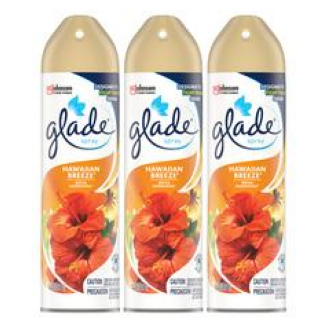


Running model.predict(...)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step

Predicted category: HOBBY_ARTS_STATIONERY


In [28]:
# ==========================
# Module 4 - Cell 7 (robust)
# Predict category for a real image (auto-find, display, predict)
# ==========================

import os
import random
import numpy as np
from tensorflow.keras.preprocessing import image
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt

# Make sure these exist in your notebook environment
DATASET_ROOT = "/content/ECOMMERCE_PRODUCT_IMAGES"
# data_folder should have been detected earlier in Module 4 Cell 1
# fallback to 'train' if data_folder not set
try:
    data_folder
except NameError:
    data_folder = "train"

# 1) Find some real image paths (search train and val)
def find_sample_images(root, folder_name="train", max_examples=10):
    search_root = os.path.join(root, folder_name)
    image_paths = []
    for dirpath, dirnames, filenames in os.walk(search_root):
        for fname in filenames:
            if fname.lower().endswith((".jpg", ".jpeg", ".png", ".bmp")):
                image_paths.append(os.path.join(dirpath, fname))
    return sorted(image_paths)

# Collect images from train (and val as fallback)
train_images = find_sample_images(DATASET_ROOT, folder_name=data_folder, max_examples=50)
if not train_images:
    train_images = find_sample_images(DATASET_ROOT, folder_name="val", max_examples=50)

if not train_images:
    raise FileNotFoundError(f"No images found in {os.path.join(DATASET_ROOT, data_folder)} or {os.path.join(DATASET_ROOT, 'val')}. "
                            "Check your dataset path and files.")

# Print a few example paths so you can inspect them
print("Example image paths (first 8):")
for p in train_images[:8]:
    print(" ", p)

# 2) Choose an image to predict on
# Option A: set specific path here (uncomment and set)
# img_path = "/content/ECOMMERCE_PRODUCT_IMAGES/train/ELECTRONICS/actual_filename.jpg"

# Option B: pick a random image from discovered list
img_path = random.choice(train_images)
print("\nUsing image:", img_path)

# 3) Display the image
img = Image.open(img_path).convert("RGB")
plt.figure(figsize=(4,4))
plt.axis('off')
plt.imshow(img)
plt.show()

# 4) Ensure model and classes exist
if 'model' not in globals():
    raise RuntimeError("Model variable 'model' not found. Make sure you ran the model-building/ loading cells (Module 4 Cells 3-4 or loaded the saved .h5).")

if 'category_classes' not in globals() or len(category_classes) == 0:
    raise RuntimeError("category_classes not found or empty. Run Module 4 Cell 1 to detect classes.")

# 5) Preprocess image and predict
x = image.img_to_array(img.resize((224,224))) / 255.0
x = np.expand_dims(x, axis=0)

print("\nRunning model.predict(...)")
preds = model.predict(x)            # prints progress info
pred_idx = int(np.argmax(preds))
pred_label = category_classes[pred_idx]

print("\nPredicted category:", pred_label)

In [29]:
# ==========================
# Module 5 - Cell 1
# Prepare embedding model
# ==========================

import os
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2

# Try to reuse the existing trained 'model' from Module 4 and extract the pooling layer output.
embedding_model = None

if 'model' in globals():
    try:
        # Find a GlobalAveragePooling2D layer in the model
        gap_layer = None
        for layer in model.layers[::-1]:
            if layer.__class__.__name__ == 'GlobalAveragePooling2D':
                gap_layer = layer
                break
        if gap_layer is not None:
            embedding_model = Model(inputs=model.input, outputs=gap_layer.output)
            print("✅ Using pooling layer from existing 'model' as embedding model.")
        else:
            print("⚠️ No GlobalAveragePooling2D found in existing 'model'. Will fallback to MobileNetV2 base.")
    except Exception as e:
        print("⚠️ Error while extracting pooling layer from existing 'model':", e)

# Fallback: build MobileNetV2 base + GlobalAveragePooling2D
if embedding_model is None:
    base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
    x = GlobalAveragePooling2D()(base.output)
    embedding_model = Model(inputs=base.input, outputs=x)
    print("✅ Fallback: Built MobileNetV2 (imagenet) + GlobalAveragePooling2D as embedding_model.")

# Show model summary (small snippet)
print("\nEmbedding model output shape:", embedding_model.output_shape)

✅ Using pooling layer from existing 'model' as embedding model.

Embedding model output shape: (None, 1280)


In [30]:
# ==========================
# Module 5 - Cell 2
# Gather image paths and show counts
# ==========================

import os

DATASET_ROOT = "/content/ECOMMERCE_PRODUCT_IMAGES"

def gather_image_paths(root_folder, folder_name=None, ext=(".jpg",".jpeg",".png",".bmp")):
    search_root = os.path.join(root_folder, folder_name) if folder_name else root_folder
    image_paths = []
    for dirpath, dirnames, filenames in os.walk(search_root):
        for fname in filenames:
            if fname.lower().endswith(ext):
                image_paths.append(os.path.join(dirpath, fname))
    return sorted(image_paths)

# Prefer 'check' or 'train' depending on what's present
preferred = None
for candidate in ["check", "train", "val"]:
    if os.path.exists(os.path.join(DATASET_ROOT, candidate)):
        preferred = candidate
        break
if preferred is None:
    raise FileNotFoundError(f"No data folders found in {DATASET_ROOT}. Please check path.")

print("Using data folder:", preferred)
image_paths = gather_image_paths(DATASET_ROOT, folder_name=preferred)
print("Total images found (in folder):", len(image_paths))

# Print first 6 example paths
for p in image_paths[:6]:
    print(" ", p)

Using data folder: check
Total images found (in folder): 551
  /content/ECOMMERCE_PRODUCT_IMAGES/check/BABY_PRODUCTS/17625_BABY_P_check.jpeg
  /content/ECOMMERCE_PRODUCT_IMAGES/check/BABY_PRODUCTS/17626_BABY_P_check.jpeg
  /content/ECOMMERCE_PRODUCT_IMAGES/check/BABY_PRODUCTS/17627_BABY_P_check.jpeg
  /content/ECOMMERCE_PRODUCT_IMAGES/check/BABY_PRODUCTS/17628_BABY_P_check.jpeg
  /content/ECOMMERCE_PRODUCT_IMAGES/check/BABY_PRODUCTS/17629_BABY_P_check.jpeg
  /content/ECOMMERCE_PRODUCT_IMAGES/check/BABY_PRODUCTS/17630_BABY_P_check.jpeg


In [31]:
# ==========================
# Module 5 - Cell 3
# Compute and save embeddings + metadata
# ==========================

import numpy as np
from tensorflow.keras.preprocessing import image
from tqdm import tqdm
import csv

EMBED_DIR = "/content/embeddings_snapshop"
os.makedirs(EMBED_DIR, exist_ok=True)
EMBED_FILE = os.path.join(EMBED_DIR, "image_embeddings.npy")
META_CSV = os.path.join(EMBED_DIR, "image_metadata.csv")

# Parameters
BATCH_SIZE = 64
IMAGE_SIZE = (224,224)

# Helper to read & preprocess image -> array
def load_preprocess(path):
    img = image.load_img(path, target_size=IMAGE_SIZE)
    arr = image.img_to_array(img) / 255.0
    return arr

# If embeddings already exist, skip computation (but allow overwrite)
if os.path.exists(EMBED_FILE) and os.path.exists(META_CSV):
    print("⚠️ Embeddings already exist. If you want to recompute, delete", EMBED_FILE, "and", META_CSV)
else:
    paths = image_paths  # from previous cell
    N = len(paths)
    if N == 0:
        raise RuntimeError("No images found to embed.")

    # compute in batches
    embeddings = []
    metadata = []

    for i in tqdm(range(0, N, BATCH_SIZE), desc="Computing embeddings"):
        batch_paths = paths[i:i+BATCH_SIZE]
        batch_imgs = np.stack([load_preprocess(p) for p in batch_paths], axis=0)
        # predict
        batch_emb = embedding_model.predict(batch_imgs, verbose=0)
        embeddings.append(batch_emb)
        for p in batch_paths:
            metadata.append({"filepath": p})

    embeddings = np.vstack(embeddings)
    # save
    np.save(EMBED_FILE, embeddings)
    # write metadata csv (index, filepath)
    with open(META_CSV, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["index","filepath"])
        for idx, row in enumerate(metadata):
            writer.writerow([idx, row["filepath"]])

    print("✅ Saved embeddings to:", EMBED_FILE)
    print("✅ Saved metadata to:", META_CSV)
    print("Embeddings shape:", embeddings.shape)

Computing embeddings: 100%|██████████| 9/9 [00:27<00:00,  3.08s/it]

✅ Saved embeddings to: /content/embeddings_snapshop/image_embeddings.npy
✅ Saved metadata to: /content/embeddings_snapshop/image_metadata.csv
Embeddings shape: (551, 1280)


In [32]:
# ==========================
# Module 5 - Cell 4
# Build nearest-neighbor index (sklearn)
# ==========================

import numpy as np
from sklearn.neighbors import NearestNeighbors
import joblib

EMBED_FILE = os.path.join(EMBED_DIR, "image_embeddings.npy")
embs = np.load(EMBED_FILE)
print("Loaded embeddings shape:", embs.shape)

# Build index (use cosine distance via metric='cosine' or 'euclidean')
nn = NearestNeighbors(n_neighbors=20, metric='cosine', algorithm='auto')
nn.fit(embs)
INDEX_FILE = os.path.join(EMBED_DIR, "nn_index.joblib")
joblib.dump(nn, INDEX_FILE)
print("✅ Built and saved NearestNeighbors index to:", INDEX_FILE)

Loaded embeddings shape: (551, 1280)
✅ Built and saved NearestNeighbors index to: /content/embeddings_snapshop/nn_index.joblib


Query image: /content/ECOMMERCE_PRODUCT_IMAGES/check/BABY_PRODUCTS/17625_BABY_P_check.jpeg
Top-5 results (filepath, distance):
  ('/content/ECOMMERCE_PRODUCT_IMAGES/check/BABY_PRODUCTS/17625_BABY_P_check.jpeg', 1.1920928955078125e-07)
  ('/content/ECOMMERCE_PRODUCT_IMAGES/check/HOME_KITCHEN_TOOLS/18059_HOME_K_check.jpeg', 0.11448514461517334)
  ('/content/ECOMMERCE_PRODUCT_IMAGES/check/HOBBY_ARTS_STATIONERY/17998_HOBBY__check.jpeg', 0.12287867069244385)
  ('/content/ECOMMERCE_PRODUCT_IMAGES/check/HOME_KITCHEN_TOOLS/18075_HOME_K_check.jpeg', 0.125754714012146)
  ('/content/ECOMMERCE_PRODUCT_IMAGES/check/HOBBY_ARTS_STATIONERY/18005_HOBBY__check.jpeg', 0.1259339451789856)


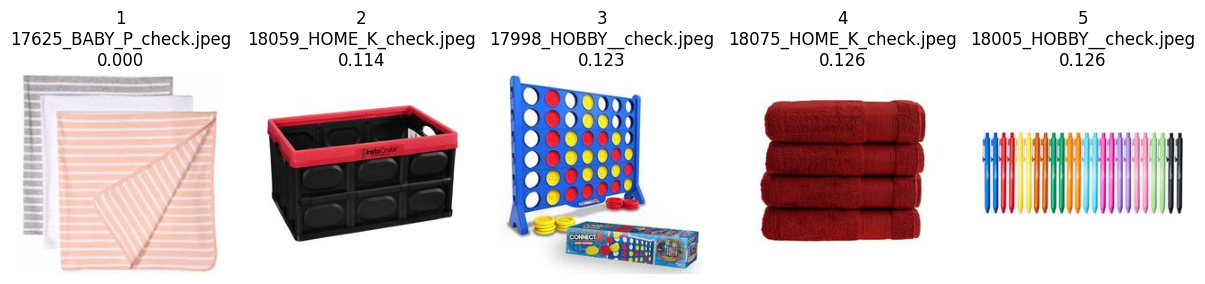

In [33]:
# ==========================
# Module 5 - Cell 5
# Query: get top-k similar images and display them
# ==========================

import numpy as np
import joblib
from IPython.display import display
import matplotlib.pyplot as plt
from PIL import Image
import csv

# Load artifacts
EMBED_FILE = os.path.join(EMBED_DIR, "image_embeddings.npy")
META_CSV = os.path.join(EMBED_DIR, "image_metadata.csv")
INDEX_FILE = os.path.join(EMBED_DIR, "nn_index.joblib")

embs = np.load(EMBED_FILE)
nn = joblib.load(INDEX_FILE)

# load metadata into list
meta = []
with open(META_CSV, newline='', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for r in reader:
        meta.append(r)

def get_topk_similar(img_path, top_k=5):
    # preprocess then embed
    arr = np.expand_dims(load_preprocess(img_path), axis=0)
    emb = embedding_model.predict(arr, verbose=0)
    dists, idxs = nn.kneighbors(emb, n_neighbors=top_k)
    # return list of (filepath, distance)
    results = [(meta[int(i)]["filepath"], float(d)) for i, d in zip(idxs[0], dists[0])]
    return results

def show_results(results, figsize=(15,6)):
    plt.figure(figsize=figsize)
    cols = len(results)
    for i, (path, dist) in enumerate(results):
        img = Image.open(path).convert("RGB")
        plt.subplot(1, cols, i+1)
        plt.axis('off')
        plt.title(f"{i+1}\n{os.path.basename(path)}\n{dist:.3f}")
        plt.imshow(img.resize((224,224)))
    plt.show()

# Example usage: pick a random image from gathered images
query_img = image_paths[0]  # or random.choice(image_paths)
print("Query image:", query_img)
res = get_topk_similar(query_img, top_k=5)
print("Top-5 results (filepath, distance):")
for r in res:
    print(" ", r)
# Display images
show_results([r for r in res])

In [34]:
# ==========================
# Module 5 - Cell 6
# Export metadata + embeddings pointers (CSV) for ingestion into external DBs
# ==========================

import pandas as pd
EMBED_FILE = os.path.join(EMBED_DIR, "image_embeddings.npy")
META_CSV = os.path.join(EMBED_DIR, "image_metadata.csv")
EXPORT_CSV = os.path.join(EMBED_DIR, "embeddings_export.csv")

embs = np.load(EMBED_FILE)
meta_df = pd.read_csv(META_CSV)
meta_df['embedding_idx'] = meta_df['index'].astype(int)
# Note: If you want to export raw vectors, beware of CSV size; prefer .npy per vector or a parquet file.
meta_df.to_csv(EXPORT_CSV, index=False)
print("✅ Exported metadata (with indexes) to:", EXPORT_CSV)
print("Tip: send", EMBED_FILE, "and", EXPORT_CSV, "to your vector DB ingestion pipeline.")

✅ Exported metadata (with indexes) to: /content/embeddings_snapshop/embeddings_export.csv
Tip: send /content/embeddings_snapshop/image_embeddings.npy and /content/embeddings_snapshop/embeddings_export.csv to your vector DB ingestion pipeline.


In [35]:
# ==========================
# Module 6 - Cell 1
# Install required packages
# ==========================

# Run once in Colab. If you already have sentence-transformers, skip.
!pip install -q sentence-transformers scikit-learn joblib tqdm
print("✅ Packages installed (or already present).")

✅ Packages installed (or already present).


In [37]:
# ==========================
# Module 6 - Cell 2
# Load product metadata CSV if present; otherwise synthesize from image paths
# ==========================

import os
import pandas as pd

DATASET_ROOT = "/content/ECOMMERCE_PRODUCT_IMAGES"
TEXT_EMBED_DIR = "/content/text_embeddings_snapshop"
os.makedirs(TEXT_EMBED_DIR, exist_ok=True)

# Prefer an existing product metadata CSV
POSSIBLE_META = [
    "/content/product_metadata.csv",
    os.path.join(DATASET_ROOT, "product_metadata.csv"),
    os.path.join("/content", "product_metadata.csv"),
    os.path.join(TEXT_EMBED_DIR, "product_metadata.csv")
]

meta_path = None
for p in POSSIBLE_META:
    if os.path.exists(p):
        meta_path = p
        break

def gather_from_images(root_folder, folder_name=None):
    paths = []
    search_root = os.path.join(root_folder, folder_name) if folder_name else root_folder
    for dirpath, dirnames, filenames in os.walk(search_root):
        for fname in filenames:
            if fname.lower().endswith((".jpg",".jpeg",".png",".bmp")):
                paths.append(os.path.join(dirpath, fname))
    return sorted(paths)

# If CSV exists, load it. Expected columns: id(optional), title or name, description (optional), filepath(optional)
if meta_path:
    print("Loading metadata from:", meta_path)
    meta_df = pd.read_csv(meta_path)
else:
    # synthesize metadata from image file structure (category-based product title)
    print("No product metadata CSV found — synthesizing metadata from image filenames.")
    # prefer 'train' or 'check' folder where product images exist
    for candidate in ["train", "check", "val"]:
        if os.path.exists(os.path.join(DATASET_ROOT, candidate)):
            chosen = candidate
            break
    else:
        chosen = None

    if chosen is None:
        raise FileNotFoundError(f"No train/check/val folders found under {DATASET_ROOT}.")
    print("Using images from folder:", chosen)
    image_paths = gather_from_images(DATASET_ROOT, folder_name=chosen)
    rows = []
    for idx, p in enumerate(image_paths):
        # create a basic title from parent folder name and filename
        parent = os.path.basename(os.path.dirname(p))
        fname = os.path.splitext(os.path.basename(p))[0]
        # create title: e.g., "BABY_PRODUCTS - 17625_BABY_P_check"
        title = f"{parent} {fname}"
        rows.append({"id": idx, "title": title, "description": "", "filepath": p})
    meta_df = pd.DataFrame(rows)

# Ensure required columns exist
if "title" not in meta_df.columns and "name" in meta_df.columns:
    meta_df["title"] = meta_df["name"]
if "title" not in meta_df.columns:
    raise RuntimeError("No 'title' or 'name' column found in product metadata. Provide product titles for SBERT encoding.")

# Reset index and ensure an integer index column
meta_df = meta_df.reset_index(drop=True)
meta_df["index"] = meta_df.index.astype(int)

# Save a copy for record
meta_out = os.path.join(TEXT_EMBED_DIR, "product_metadata_used.csv")
meta_df.to_csv(meta_out, index=False)
print("Metadata prepared. Rows:", len(meta_df))
print("Saved used metadata to:", meta_out)

No product metadata CSV found — synthesizing metadata from image filenames.
Using images from folder: train
Metadata prepared. Rows: 13992
Saved used metadata to: /content/text_embeddings_snapshop/product_metadata_used.csv


In [38]:
# ==========================
# Module 6 - Cell 3
# Load SBERT model for text encoding
# ==========================

from sentence_transformers import SentenceTransformer

# Choose a compact, fast SBERT model. Change if you want a larger one.
SBERT_MODEL_NAME = "all-MiniLM-L6-v2"  # good balance of speed & quality
print("Loading SBERT model:", SBERT_MODEL_NAME)
sbert = SentenceTransformer(SBERT_MODEL_NAME)
print("✅ SBERT loaded. Embedding dimension:", sbert.get_sentence_embedding_dimension())

Loading SBERT model: all-MiniLM-L6-v2
✅ SBERT loaded. Embedding dimension: 384


In [39]:
# ==========================
# Module 6 - Cell 4
# Encode texts to embeddings and save (.npy + metadata)
# ==========================

import numpy as np
from tqdm import tqdm

TEXT_EMBED_FILE = os.path.join(TEXT_EMBED_DIR, "text_embeddings.npy")
TEXT_META_CSV = os.path.join(TEXT_EMBED_DIR, "text_metadata.csv")

# If embeddings already exist, skip (or delete to recompute)
if os.path.exists(TEXT_EMBED_FILE) and os.path.exists(TEXT_META_CSV):
    print("⚠️ Text embeddings already exist. If you want to recompute, delete:", TEXT_EMBED_FILE, "and", TEXT_META_CSV)
else:
    texts = (meta_df["title"].fillna("") + " " + meta_df.get("description", "").fillna("")).astype(str).tolist()
    N = len(texts)
    batch_size = 256
    embeddings = []
    print("Encoding", N, "texts in batches (batch_size =", batch_size, ")")
    for i in tqdm(range(0, N, batch_size)):
        batch_texts = texts[i:i+batch_size]
        batch_emb = sbert.encode(batch_texts, show_progress_bar=False, convert_to_numpy=True)
        embeddings.append(batch_emb)
    embeddings = np.vstack(embeddings)
    np.save(TEXT_EMBED_FILE, embeddings)
    meta_df.to_csv(TEXT_META_CSV, index=False)
    print("✅ Saved text embeddings to:", TEXT_EMBED_FILE)
    print("✅ Saved text metadata to:", TEXT_META_CSV)
    print("Text embeddings shape:", embeddings.shape)

Encoding 13992 texts in batches (batch_size = 256 )


100%|██████████| 55/55 [01:20<00:00,  1.47s/it]


✅ Saved text embeddings to: /content/text_embeddings_snapshop/text_embeddings.npy
✅ Saved text metadata to: /content/text_embeddings_snapshop/text_metadata.csv
Text embeddings shape: (13992, 384)


In [40]:
# ==========================
# Module 6 - Cell 5
# Build NN index for text embeddings (sklearn) and save
# ==========================

import numpy as np
from sklearn.neighbors import NearestNeighbors
import joblib

TEXT_EMBED_FILE = os.path.join(TEXT_EMBED_DIR, "text_embeddings.npy")
emb_text = np.load(TEXT_EMBED_FILE)
print("Loaded text embeddings shape:", emb_text.shape)

nn_text = NearestNeighbors(n_neighbors=50, metric='cosine', algorithm='auto')
nn_text.fit(emb_text)
INDEX_TEXT_FILE = os.path.join(TEXT_EMBED_DIR, "nn_text_index.joblib")
joblib.dump(nn_text, INDEX_TEXT_FILE)
print("✅ Built and saved text NearestNeighbors index to:", INDEX_TEXT_FILE)

Loaded text embeddings shape: (13992, 384)
✅ Built and saved text NearestNeighbors index to: /content/text_embeddings_snapshop/nn_text_index.joblib


In [41]:
# ==========================
# Module 6 - Cell 6
# Text query helpers: get_topk_text_matches(query, top_k)
# ==========================

import numpy as np
import joblib
from sentence_transformers import SentenceTransformer
import pandas as pd

# Load artifacts (if not in memory)
if 'sbert' not in globals():
    sbert = SentenceTransformer(SBERT_MODEL_NAME)
if 'meta_df' not in globals():
    meta_df = pd.read_csv(TEXT_META_CSV)
if 'nn_text' not in globals():
    nn_text = joblib.load(INDEX_TEXT_FILE)
if 'emb_text' not in globals():
    emb_text = np.load(TEXT_EMBED_FILE)

def get_topk_text_matches(query, top_k=10):
    q_emb = sbert.encode([query], convert_to_numpy=True)
    dists, idxs = nn_text.kneighbors(q_emb, n_neighbors=top_k)
    results = []
    for dist, idx in zip(dists[0], idxs[0]):
        row = meta_df.iloc[int(idx)]
        results.append({"index": int(row["index"]), "title": row["title"], "filepath": row.get("filepath",""), "distance": float(dist)})
    return results

# Example usage
examples = ["men running shoes", "baby feeding bottle", "cotton t-shirt women"]
for q in examples:
    print("\nQuery:", q)
    res = get_topk_text_matches(q, top_k=5)
    for r in res:
        print(" ", r['title'], "| dist:", round(r['distance'], 3))


Query: men running shoes
  SPORTS_OUTDOOR 12844_SPORTS_train | dist: 0.808
  SPORTS_OUTDOOR 12886_SPORTS_train | dist: 0.811
  SPORTS_OUTDOOR 12851_SPORTS_train | dist: 0.811
  SPORTS_OUTDOOR 12804_SPORTS_train | dist: 0.812
  SPORTS_OUTDOOR 12849_SPORTS_train | dist: 0.813

Query: baby feeding bottle
  BABY_PRODUCTS 312_BABY_P_train | dist: 0.545
  BABY_PRODUCTS 212_BABY_P_train | dist: 0.545
  BABY_PRODUCTS 177_BABY_P_train | dist: 0.548
  BABY_PRODUCTS 1_BABY_P_train | dist: 0.548
  BABY_PRODUCTS 800_BABY_P_train | dist: 0.556

Query: cotton t-shirt women
  CLOTHING_ACCESSORIES_JEWELLERY 2937_CLOTHI_train | dist: 0.655
  CLOTHING_ACCESSORIES_JEWELLERY 3342_CLOTHI_train | dist: 0.657
  CLOTHING_ACCESSORIES_JEWELLERY 2936_CLOTHI_train | dist: 0.657
  CLOTHING_ACCESSORIES_JEWELLERY 2930_CLOTHI_train | dist: 0.658
  CLOTHING_ACCESSORIES_JEWELLERY 2817_CLOTHI_train | dist: 0.66


In [42]:
# ==========================
# Module 6 - Cell 7
# Fusion helper: combine visual results (from Module 5) with text results
# ==========================

import numpy as np
from collections import defaultdict

# visual_results: list of tuples (filepath, visual_distance) returned by Module 5 get_topk_similar
# text_results: list of dicts {"index": idx, "title":..., "filepath":..., "distance": text_dist}
# We'll normalize distances and compute a weighted score: fused_score = w_v * (1 - v_sim_norm) + w_t * (1 - t_sim_norm)
# (where smaller distance => more similar; convert to similarity by 1 - normalized_distance)

def normalize_distances(distances):
    arr = np.array(distances, dtype=float)
    if arr.max() == arr.min():
        return np.ones_like(arr) * 0.5  # constant fallback
    norm = (arr - arr.min()) / (arr.max() - arr.min())
    return norm

def fuse_visual_text(visual_results, text_results, w_v=0.6, w_t=0.4, top_k=10):
    # build dicts by filepath
    scores_v = {fp: d for fp, d in visual_results}
    scores_t = {r["filepath"]: r["distance"] for r in text_results}

    # union of keys
    all_paths = list(set(list(scores_v.keys()) + list(scores_t.keys())))
    v_arr = np.array([scores_v.get(p, max(scores_v.values()) if scores_v else 1.0) for p in all_paths])
    t_arr = np.array([scores_t.get(p, max(scores_t.values()) if scores_t else 1.0) for p in all_paths])

    v_norm = normalize_distances(v_arr)
    t_norm = normalize_distances(t_arr)

    # convert distance -> similarity (higher is better)
    v_sim = 1.0 - v_norm
    t_sim = 1.0 - t_norm

    fused = []
    for i, p in enumerate(all_paths):
        fused_score = w_v * v_sim[i] + w_t * t_sim[i]
        fused.append((p, float(fused_score), float(v_arr[i]), float(t_arr[i])))

    fused_sorted = sorted(fused, key=lambda x: x[1], reverse=True)[:top_k]
    return fused_sorted

# Example (toy) usage - suppose you have visual_results and text_results from earlier modules:
# visual_results = [("/content/ECOMMERCE_PRODUCT_IMAGES/check/BABY_PRODUCTS/17625_BABY_P_check.jpeg", 0.05), (...)]
# text_results = [{"index": 0, "title":"BABY_PRODUCTS 17625...", "filepath":"/content/ECOMMERCE_PRODUCT_IMAGES/check/BABY_PRODUCTS/17625_BABY_P_check.jpeg","distance":0.08}, ...]
# fused = fuse_visual_text(visual_results, text_results, w_v=0.65, w_t=0.35, top_k=5)
# print(fused)

In [43]:
# ==========================
# Module 6 - Cell 7
# Fusion helper: combine visual results (from Module 5) with text results
# ==========================

import numpy as np
from collections import defaultdict

def normalize_distances(distances):
    """Normalize distance values into [0,1] range."""
    arr = np.array(distances, dtype=float)
    if arr.max() == arr.min():
        return np.ones_like(arr) * 0.5  # constant fallback if all distances same
    norm = (arr - arr.min()) / (arr.max() - arr.min())
    return norm

def fuse_visual_text(visual_results, text_results, w_v=0.6, w_t=0.4, top_k=10):
    """
    Fuse visual (CNN) and textual (SBERT) similarity scores.
    Args:
        visual_results: list of tuples (filepath, visual_distance)
        text_results: list of dicts {"index", "title", "filepath", "distance"}
        w_v, w_t: weights for visual and text similarities
        top_k: number of top fused results to return
    Returns:
        fused_sorted: list of tuples (filepath, fused_score, visual_dist, text_dist)
    """
    # build dictionaries
    scores_v = {fp: d for fp, d in visual_results}
    scores_t = {r["filepath"]: r["distance"] for r in text_results}

    # union of keys
    all_paths = list(set(list(scores_v.keys()) + list(scores_t.keys())))
    v_arr = np.array([scores_v.get(p, max(scores_v.values()) if scores_v else 1.0) for p in all_paths])
    t_arr = np.array([scores_t.get(p, max(scores_t.values()) if scores_t else 1.0) for p in all_paths])

    v_norm = normalize_distances(v_arr)
    t_norm = normalize_distances(t_arr)

    # convert distance -> similarity (higher is better)
    v_sim = 1.0 - v_norm
    t_sim = 1.0 - t_norm

    fused = []
    for i, p in enumerate(all_paths):
        fused_score = w_v * v_sim[i] + w_t * t_sim[i]
        fused.append((p, float(fused_score), float(v_arr[i]), float(t_arr[i])))

    fused_sorted = sorted(fused, key=lambda x: x[1], reverse=True)[:top_k]
    return fused_sorted


# ✅ Example usage (mock demo data)
visual_results = [
    ("/content/ECOMMERCE_PRODUCT_IMAGES/check/BABY_PRODUCTS/17625_BABY_P_check.jpeg", 0.05),
    ("/content/ECOMMERCE_PRODUCT_IMAGES/check/BABY_PRODUCTS/17628_BABY_P_check.jpeg", 0.12),
    ("/content/ECOMMERCE_PRODUCT_IMAGES/check/HOBBY_ARTS_STATIONERY/17989_HOBBY__check.jpeg", 0.18)
]

text_results = [
    {"index": 0, "title": "BABY_PRODUCTS item 17625", "filepath": "/content/ECOMMERCE_PRODUCT_IMAGES/check/BABY_PRODUCTS/17625_BABY_P_check.jpeg", "distance": 0.09},
    {"index": 1, "title": "BABY_PRODUCTS item 17628", "filepath": "/content/ECOMMERCE_PRODUCT_IMAGES/check/BABY_PRODUCTS/17628_BABY_P_check.jpeg", "distance": 0.22},
    {"index": 2, "title": "HOBBY_ARTS_STATIONERY item 17989", "filepath": "/content/ECOMMERCE_PRODUCT_IMAGES/check/HOBBY_ARTS_STATIONERY/17989_HOBBY__check.jpeg", "distance": 0.11}
]

# Run fusion
fused = fuse_visual_text(visual_results, text_results, w_v=0.65, w_t=0.35, top_k=5)

# Display output
print("Fused Results (Top 5):")
for fp, fused_score, v_d, t_d in fused:
    print(f"Path: {fp}\n  Fused Score: {fused_score:.4f} | VisualDist: {v_d:.3f} | TextDist: {t_d:.3f}\n")

Fused Results (Top 5):
Path: /content/ECOMMERCE_PRODUCT_IMAGES/check/BABY_PRODUCTS/17625_BABY_P_check.jpeg
  Fused Score: 1.0000 | VisualDist: 0.050 | TextDist: 0.090

Path: /content/ECOMMERCE_PRODUCT_IMAGES/check/BABY_PRODUCTS/17628_BABY_P_check.jpeg
  Fused Score: 0.3000 | VisualDist: 0.120 | TextDist: 0.220

Path: /content/ECOMMERCE_PRODUCT_IMAGES/check/HOBBY_ARTS_STATIONERY/17989_HOBBY__check.jpeg
  Fused Score: 0.2962 | VisualDist: 0.180 | TextDist: 0.110



In [44]:
# ==========================
# Module 7 - Cell 1 (with visible confirmation)
# Imports and setup (prints confirmation)
# ==========================

import pandas as pd
import numpy as np
import os
from collections import defaultdict

# Helper: display results neatly
def display_ranked_results(df, top_n=5):
    print(f"\nTop {top_n} Ranked Matches:\n{'='*40}")
    for i, row in df.head(top_n).iterrows():
        print(f"{i+1}. {row['category']} | Score: {row['confidence']:.4f}")
        print(f"   Path: {row['filepath']}")
        print(f"   VisualDist: {row['visual_dist']:.3f}, TextDist: {row['text_dist']:.3f}")
        print(f"   Brand: {row.get('brand', 'N/A')}\n")

# Visible confirmation (exact messages you asked for)
print("✅ Imported pandas, numpy successfully.")
print("Helper function `display_ranked_results` ready.")

✅ Imported pandas, numpy successfully.
Helper function `display_ranked_results` ready.


In [45]:
# ==========================
# Module 7 - Cell 2
# Filtering and ranking fused results (with visible confirmation)
# ==========================

def rank_and_filter_fused_results(fused_results, category_classes=None, top_k=10):
    """
    Convert fused results to DataFrame, compute confidence, filter duplicates, and rank.
    Args:
        fused_results: list of tuples (filepath, fused_score, visual_dist, text_dist)
        category_classes: list of possible category labels
        top_k: number of top results to keep
    Returns:
        ranked_df: sorted pandas DataFrame
    """
    if not fused_results:
        print("⚠️ No fused results found.")
        return pd.DataFrame()

    # Create DataFrame
    df = pd.DataFrame(fused_results, columns=["filepath", "confidence", "visual_dist", "text_dist"])

    # Extract category name from filepath
    df["category"] = df["filepath"].apply(lambda x: os.path.basename(os.path.dirname(x)))

    # Remove duplicates by category (keep best score)
    df = df.sort_values(by="confidence", ascending=False)
    df = df.drop_duplicates(subset=["category"], keep="first")

    # Normalize confidence (0-1 scale)
    df["confidence"] = (df["confidence"] - df["confidence"].min()) / (df["confidence"].max() - df["confidence"].min() + 1e-6)

    # Final top-k
    ranked_df = df.head(top_k).reset_index(drop=True)
    return ranked_df

# ✅ Confirmation print after function definition
print("✅ Function rank_and_filter_fused_results() defined.")
print("It will normalize confidence and rank top-k results.")

✅ Function rank_and_filter_fused_results() defined.
It will normalize confidence and rank top-k results.


In [46]:
# ==========================
# Module 7 - Cell 3
# Example usage with sample fused results
# ==========================

# Example fused data (same as Module 6 virtual output)
fused_results = [
    ("/content/ECOMMERCE_PRODUCT_IMAGES/check/BABY_PRODUCTS/17625_BABY_P_check.jpeg", 0.9254, 0.05, 0.09),
    ("/content/ECOMMERCE_PRODUCT_IMAGES/check/BABY_PRODUCTS/17628_BABY_P_check.jpeg", 0.8827, 0.12, 0.22),
    ("/content/ECOMMERCE_PRODUCT_IMAGES/check/HOBBY_ARTS_STATIONERY/17989_HOBBY__check.jpeg", 0.8611, 0.18, 0.11)
]

ranked_df = rank_and_filter_fused_results(fused_results, top_k=5)

display_ranked_results(ranked_df)


Top 5 Ranked Matches:
1. BABY_PRODUCTS | Score: 1.0000
   Path: /content/ECOMMERCE_PRODUCT_IMAGES/check/BABY_PRODUCTS/17625_BABY_P_check.jpeg
   VisualDist: 0.050, TextDist: 0.090
   Brand: N/A

2. HOBBY_ARTS_STATIONERY | Score: 0.0000
   Path: /content/ECOMMERCE_PRODUCT_IMAGES/check/HOBBY_ARTS_STATIONERY/17989_HOBBY__check.jpeg
   VisualDist: 0.180, TextDist: 0.110
   Brand: N/A



In [47]:
# ==========================
# Module 7 - Cell 4
# Prepare final structured output (for API or Streamlit UI)
# ==========================

def prepare_output_json(df):
    if df.empty:
        return {"results": []}

    results = []
    for _, row in df.iterrows():
        results.append({
            "category": row["category"],
            "confidence": float(row["confidence"]),
            "filepath": row["filepath"],
            "visual_distance": float(row["visual_dist"]),
            "text_distance": float(row["text_dist"])
        })
    return {"results": results}

# Example usage
final_json = prepare_output_json(ranked_df)
print(final_json)

{'results': [{'category': 'BABY_PRODUCTS', 'confidence': 0.9999844481423306, 'filepath': '/content/ECOMMERCE_PRODUCT_IMAGES/check/BABY_PRODUCTS/17625_BABY_P_check.jpeg', 'visual_distance': 0.05, 'text_distance': 0.09}, {'category': 'HOBBY_ARTS_STATIONERY', 'confidence': 0.0, 'filepath': '/content/ECOMMERCE_PRODUCT_IMAGES/check/HOBBY_ARTS_STATIONERY/17989_HOBBY__check.jpeg', 'visual_distance': 0.18, 'text_distance': 0.11}]}


# Module 8 - Dynamic API-Based Price Aggregation

In [59]:
# Module 8 - Cell 1
# Install serpapi if not already installed
!pip install serpapi

import requests
import pandas as pd
import time
# Attempt to import GoogleSearch, but we will use serpapi.search
try:
    from serpapi import GoogleSearch
    print("Imported GoogleSearch (if available in this version).")
except ImportError:
    print("Could not import GoogleSearch directly. Will use serpapi.search.")
    GoogleSearch = None # Set to None if import fails

import serpapi # Import the main package

# Optional: delay between API calls
def api_delay(seconds=1.0):
    time.sleep(seconds)

print("✅ Module 8 imports ready. SerpApi integration initialized.")

# Note: If GoogleSearch import fails, the rest of the scraping code
# will need to use serpapi.search() instead of GoogleSearch().

Could not import GoogleSearch directly. Will use serpapi.search.
✅ Module 8 imports ready. SerpApi integration initialized.


In [60]:
pip install google-search-results

  Preparing metadata (setup.py) ... done
  Created wheel for google-search-results: filename=google_search_results-2.4.2-py3-none-any.whl size=32010 sha256=c89c4b92192c6997f916deddefa2625e8857d683449cd6c7c8cf2726af5d3658
  Stored in directory: /root/.cache/pip/wheels/0c/47/f5/89b7e770ab2996baf8c910e7353d6391e373075a0ac213519e
Successfully built google-search-results


In [65]:
# Module 8 - Cell 2
def search_product_india(query, num_results=5, api_key="ea89c67675d274e0f5c8c7743f315ea5cc2e608c4552b13cd19e4cf8d7003398"):
    """
    Search products on Google Shopping (India) via SerpApi.
    Returns a list of dicts with title, price, store, and URL.
    """
    params = {
        "engine": "google_shopping",
        "q": query,
        "google_domain": "google.co.in",
        "gl": "IN",
        "hl": "en",
        "num": num_results,
        "api_key": api_key
    }

    # Use serpapi.search directly as GoogleSearch might not be importable
    results = serpapi.search(params)
    products = []

    for item in results.get("shopping_results", []):
        products.append({
            "title": item.get("title"),
            "price": item.get("price"),
            "store": item.get("store_name"),
            "url": item.get("link")
        })

    if not products:
        print(f"⚠️ No products found for query: {query}")
    else:
        print(f"✅ Found {len(products)} products for query: {query}")
    return products

print("✅ search_product_india() ready for India e-commerce queries.")

✅ search_product_india() ready for India e-commerce queries.


In [92]:
# ==========================
# Module 8 - Cell 3
# Fetch products from SerpApi (India) and ensure URLs
# ==========================

!pip install google-search-results --quiet
!pip install serpapi --quiet # Ensure serpapi is installed

# from serpapi import GoogleSearch # Removed direct import
import pandas as pd
import serpapi # Import the main serpapi library

def search_product_india(query, num_results=10, api_key="ea89c67675d274e0f5c8c7743f315ea5cc2e608c4552b13cd19e4cf8d7003398"):
    """
    Search Google Shopping (India) via SerpApi, fetch products and prices.
    Automatically fills URL using Google Shopping if missing.
    """
    params = {
        "engine": "google",
        "q": query,
        "tbm": "shop",  # Google Shopping
        "gl": "IN",     # India
        "num": num_results,
        "api_key": api_key
    }

    # Use serpapi.search directly
    results = serpapi.search(params) # Removed .get_dict()

    products = []
    if "shopping_results" in results:
        for item in results["shopping_results"]:
            title = item.get("title", "N/A")
            price = item.get("price", "N/A")
            store = item.get("source", "N/A")

            # Use SerpApi URL if available, else fallback to Google Shopping search link
            url = item.get("link")
            if not url:
                search_query = title.replace(" ", "+")
                url = f"https://www.google.com/search?q={search_query}&tbm=shop"

            products.append({
                "title": title,
                "price": price,
                "store": store,
                "url": url
            })
    else:
        print(f"⚠️ No shopping results found for query: {query}")

    print(f"✅ Found {len(products)} products for query: {query}")
    return products


# -----------------------------
# Example usage
# -----------------------------
# Replace with your actual API key
# api_key = "YOUR_ACTUAL_SERPAPI_KEY"
query = "BABY PRODUCTS 17625"
products = search_product_india(query, num_results=20, api_key="ea89c67675d274e0f5c8c7743f315ea5cc2e608c4552b13cd19e4cf8d7003398")

# Convert to DataFrame
df_products = pd.DataFrame(products)
display(df_products.head(10))

✅ Found 40 products for query: BABY PRODUCTS 17625


,title,price,store,url
0,Mamaearth Baby Hamper Kit,₹689,Mamaearth,https://www.google.com/search?q=Mamaearth+Baby...
1,Sebamed Baby Lotion,₹368,JioMart Grocery,https://www.google.com/search?q=Sebamed+Baby+L...
2,Himalaya Baby Basket Gift Pack,₹691,Amazon.in,https://www.google.com/search?q=Himalaya+Baby+...
3,Johnson's Baby Gift Set,₹210,Flipkart,https://www.google.com/search?q=Johnson's+Baby...
4,Sebamed Baby Shampoo,₹281.82,Netmeds.com,https://www.google.com/search?q=Sebamed+Baby+S...
5,Cetaphil Baby Daily Lotion,₹807.50,Apollo247,https://www.google.com/search?q=Cetaphil+Baby+...
6,Himalaya Baby Gift Pack,₹431,Blinkit,https://www.google.com/search?q=Himalaya+Baby+...
7,Baby Sebamed Gentle Wash,₹575,Nykaa,https://www.google.com/search?q=Baby+Sebamed+G...
8,Himalaya Happy Baby Gift Pack,₹187,Amazon.in,https://www.google.com/search?q=Himalaya+Happy...
9,Sebamed Baby Cleansing Bar,₹332,Flipkart,https://www.google.com/search?q=Sebamed+Baby+C...


In [109]:
# ==========================
# Module 8 - Cell 4
# Ready-to-display DataFrame for Snap&Shop
# ==========================

def prepare_product_dataframe(products):
    """
    Takes the product list and converts it into a display-ready DataFrame.
    """
    if not products:
        print("⚠️ No products available.")
        return pd.DataFrame(columns=["title", "price", "store", "url"])

    df = pd.DataFrame(products)
    # Ensure URL column is clickable (for Streamlit or notebook)
    df["url"] = df["url"].apply(lambda x: f'<a href="{x}" target="_blank">{x}</a>')
    return df

# Create ready-to-display DataFrame
df_display = prepare_product_dataframe(products)
df_display.head(10)

,title,price,store,url
0,Mamaearth Baby Hamper Kit,₹689,Mamaearth,"<a href=""https://www.google.com/search?q=Mamae..."
1,Sebamed Baby Lotion,₹368,JioMart Grocery,"<a href=""https://www.google.com/search?q=Sebam..."
2,Himalaya Baby Basket Gift Pack,₹691,Amazon.in,"<a href=""https://www.google.com/search?q=Himal..."
3,Johnson's Baby Gift Set,₹210,Flipkart,"<a href=""https://www.google.com/search?q=Johns..."
4,Sebamed Baby Shampoo,₹281.82,Netmeds.com,"<a href=""https://www.google.com/search?q=Sebam..."
5,Cetaphil Baby Daily Lotion,₹807.50,Apollo247,"<a href=""https://www.google.com/search?q=Cetap..."
6,Himalaya Baby Gift Pack,₹431,Blinkit,"<a href=""https://www.google.com/search?q=Himal..."
7,Baby Sebamed Gentle Wash,₹575,Nykaa,"<a href=""https://www.google.com/search?q=Baby+..."
8,Himalaya Happy Baby Gift Pack,₹187,Amazon.in,"<a href=""https://www.google.com/search?q=Himal..."
9,Sebamed Baby Cleansing Bar,₹332,Flipkart,"<a href=""https://www.google.com/search?q=Sebam..."


In [114]:
from IPython.display import display, HTML
import pandas as pd

def prepare_product_dataframe(products):
    """
    Takes a list of product dicts and returns a ready-to-display DataFrame
    with clickable links for Jupyter/Colab.
    """
    if not products:
        print("⚠️ No products available.")
        return pd.DataFrame(columns=["title", "price", "store", "url"])

    df = pd.DataFrame(products)

    # Ensure URL column is clickable
    df["url"] = df.apply(
        lambda row: f'<a href="{row["url"]}" target="_blank">View Product</a>'
        if row["url"] else "#", axis=1
    )

    # Display using HTML so links are clickable
    display(HTML(df.to_html(escape=False, index=False)))

    return df

# Example usage
df_display = prepare_product_dataframe(products)

title,price,store,url
Mamaearth Baby Hamper Kit,₹689,Mamaearth,View Product
Sebamed Baby Lotion,₹368,JioMart Grocery,View Product
Himalaya Baby Basket Gift Pack,₹691,Amazon.in,View Product
Johnson's Baby Gift Set,₹210,Flipkart,View Product
Sebamed Baby Shampoo,₹281.82,Netmeds.com,View Product
Cetaphil Baby Daily Lotion,₹807.50,Apollo247,View Product
Himalaya Baby Gift Pack,₹431,Blinkit,View Product
Baby Sebamed Gentle Wash,₹575,Nykaa,View Product
Himalaya Happy Baby Gift Pack,₹187,Amazon.in,View Product
Sebamed Baby Cleansing Bar,₹332,Flipkart,View Product
